In [50]:
import pandas as pd
import seaborn as sns
import os

In [59]:
dfs = []

bench_dir = "bench"

for cmd in os.listdir(bench_dir):
    for store_config in os.listdir(os.path.join(bench_dir, cmd)):
        parts = store_config.split("-")
        store = parts[0]
        tls = parts[1] != "notls"
        enclave = parts[2]
        
        file = os.path.join(bench_dir, cmd, store_config, "timings.csv")
        if not os.path.exists(file):
            continue
        df = pd.read_csv(file)
        start = df['start_micros'].min()
        df['start_micros'] -= start
        df['end_micros'] -= start
        df['latency_ms'] = (df['end_micros'] - df['start_micros']) / 1000
        df["cmd"] = cmd
        df["store"] = store
        df["tls"] = tls
        df["enclave"] = enclave
        dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)

In [60]:
all_data[all_data.latency_ms < 0]

,start_micros,end_micros,latency_ms,cmd,store,tls,enclave
20120,144315,135879,-8.436,txn-mixed_txn-mixed-key,etcd,False,virtual
20722,817779,805692,-12.087,txn-mixed_txn-mixed-key,etcd,False,virtual


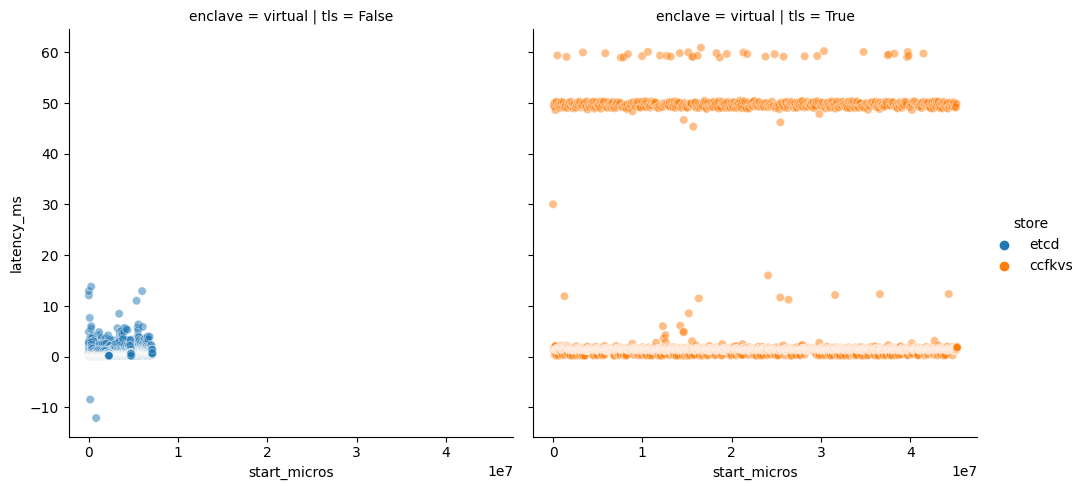

In [64]:
sns.relplot(kind="scatter", data=all_data, x="start_micros", y="latency_ms", row="enclave", col="tls", hue="store", alpha=0.5)

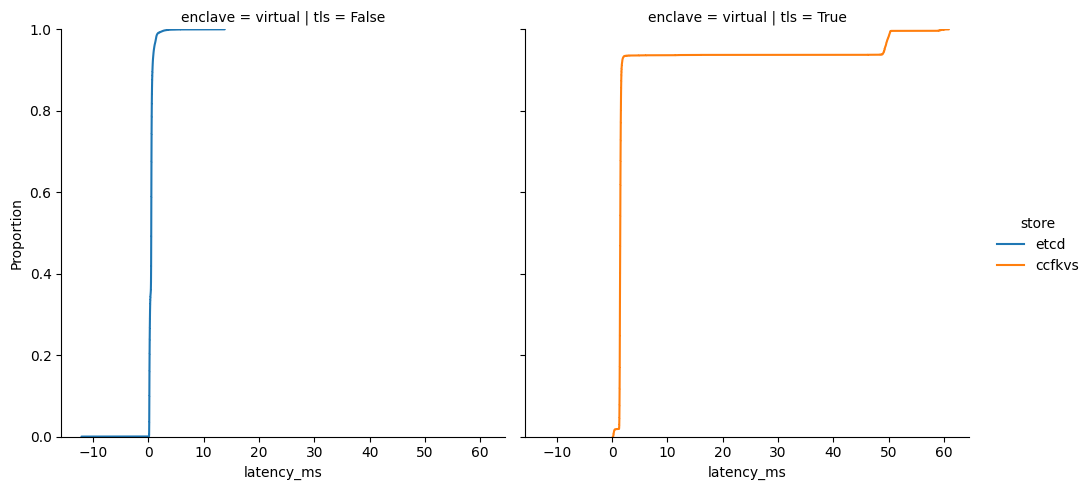

In [65]:
sns.displot(kind="ecdf", data=all_data, x="latency_ms", row="enclave", col="tls", hue="store")